In [1]:
print("Hello, lanngraph!!")

Hello, lanngraph!!


In [2]:
## tools
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query Arxiv")

print(arxiv.name)

arxiv


In [6]:
result = arxiv.invoke("Attention is all you need")

In [7]:
print(result)

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [10]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Seaches wikipedia for results")

print(wiki.name)

wikipedia


In [12]:
res = wiki.invoke("history of mysore palace")

In [13]:
print(res)

Page: Mysore Palace
Summary: Mysore Palace, also known as Amba Vilas Palace, is a historical palace and a royal residence. It is located in Mysore, Karnataka, India. It used to be the official residence of the Wadiyar dynasty and the seat of the Kingdom of Mysore. The palace is in the centre of Mysore, and faces the Chamundi Hills eastward. Mysore is commonly described as the 'City of the Palaces', and there are seven palaces including this one. However, the Mysore Palace refers specifically to 


In [14]:
from dotenv import load_dotenv
load_dotenv()

import os

#os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [15]:
## combine all tools

tools = [arxiv, wiki]

In [16]:
## initialize the LLM model

from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it")



In [17]:
llm.invoke("What is mysore pak?")

AIMessage(content="Mysore Pak is a **traditional Indian sweet** originating from the city of Mysore in Karnataka, India. \n\n**Here's what makes it special:**\n\n* **Ingredients:** It's primarily made with gram flour (besan), sugar, and ghee (clarified butter).\n* **Texture:**  It has a unique melt-in-your-mouth texture, being incredibly soft and dense.\n* **Flavor:**  The sweetness is balanced by the richness of the ghee, creating a decadent and flavorful experience.\n* **Appearance:**  It's usually golden brown in color and cut into diamond or square shapes.\n* **Occasion:** Mysore Pak is a popular offering during festivals and special occasions in South India.\n\n\nLet me know if you'd like to know more about its history, variations, or how to make it!\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 176, 'prompt_tokens': 15, 'total_tokens': 191, 'completion_time': 0.32, 'prompt_time': 0.001914717, 'queue_time': 0.242882047, 'total_time': 0.321914717

In [18]:
llm_with_tools = llm.bind_tools(tools = tools)

In [19]:
llm_with_tools.invoke("what is the gold rate in bangalore today?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mp1w', 'function': {'arguments': '{"query":"gold rate in bangalore today"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1067, 'total_tokens': 1152, 'completion_time': 0.154545455, 'prompt_time': 0.037556795, 'queue_time': 0.24567591400000002, 'total_time': 0.19210225}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--573c1b23-18fa-4b12-b2b5-5f63536a5780-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'gold rate in bangalore today'}, 'id': 'call_mp1w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1067, 'output_tokens': 85, 'total_tokens': 1152})

### workflow

In [ ]:
## state schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # human msg or AI msg
from typing import Annotated ## labelling
from langgraph.graph.message import add_messages ##reducers in langgraph

In [21]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    

In [22]:
## Entire chatbot with langgraph

from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [29]:
## node definition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


## edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # if the latest message (result) from assistant is a tool call- > tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call --> tools_condition routes to END
    
    tools_condition
)

builder.add_edge("tools",END)

In [30]:
# compile

graph = builder.compile()

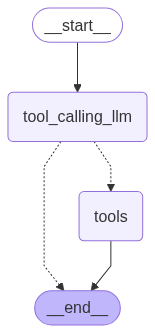

In [31]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages = graph.invoke({"messages":"1706.03762"})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_gw5p)
 Call ID: call_gw5p
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [ ]:
messages = graph.invoke({"messages":"what is the current gold price?"})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the current gold price?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_0e9v)
 Call ID: call_0e9v
  Args:
    query: gold price
================================= Tool Message =================================
Name: wikipedia

Page: Gold as an investment
Summary: Of all the precious metals, gold is the most popular as an investment. Investors generally buy gold as a way of diversifying risk, especially through the use of futures contracts and derivatives. The gold market is subject to speculation and volatility as are other markets.  Compared to other precious metals used for investment, gold has been the most effective safe haven across a number of countries.




In [38]:
messages = graph.invoke({"messages":"Hi, My name is Bharath"})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, My name is Bharath
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_gdf5)
 Call ID: call_gdf5
  Args:
    query: Bharath
================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found


c:\Users\Star\anaconda3\envs\langgraph\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Star\anaconda3\envs\langgraph\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [39]:
builder1 = StateGraph(State)
builder1.add_node("tool_calling_llm",tool_calling_llm)
builder1.add_node("tools", ToolNode(tools))


## edges

builder1.add_edge(START,"tool_calling_llm")
builder1.add_conditional_edges(
    "tool_calling_llm", 
    # if the latest message (result) from assistant is a tool call- > tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call --> tools_condition routes to END
    
    tools_condition
)

builder1.add_edge("tools","tool_calling_llm")

In [42]:
# compile

graph1 = builder1.compile()

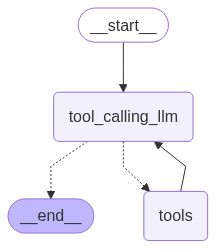

In [43]:
display(Image(graph1.get_graph().draw_mermaid_png()))

In [46]:
messages = graph1.invoke({"messages":"Gold price today"})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Gold price today
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_d02t)
 Call ID: call_d02t
  Args:
    query: gold price
================================= Tool Message =================================
Name: wikipedia

Page: Gold as an investment
Summary: Of all the precious metals, gold is the most popular as an investment. Investors generally buy gold as a way of diversifying risk, especially through the use of futures contracts and derivatives. The gold market is subject to speculation and volatility as are other markets.  Compared to other precious metals used for investment, gold has been the most effective safe haven across a number of countries.


================================== Ai Message ==================================

Gold prices fluctuate daily and are best found on a financial website or news source.


In [48]:
messages = graph1.invoke({"messages":"Hi, my name is Bharath, please give me the latest research paper on GenAI"})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Bharath, please give me the latest research paper on GenAI
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_qm79)
 Call ID: call_qm79
  Args:
    query: Generative AI
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-16
Title: AI Generations: From AI 1.0 to AI 4.0
Authors: Jiahao Wu, Hengxu You, Jing Du
Summary: This paper proposes that Artificial Intelligence (AI) progresses through
several overlapping generations: AI 1.0 (Information AI), AI 2.0 (Agentic AI),
AI 3.0 (Physical AI), and now a speculative AI 4.0 (Conscious AI). Each of
these AI generations is driven by shifting priorities among algorithms,
computing power, and data. AI 1.0 ushered in breakthroughs in pattern
recognition and
================================== Ai Message ==================================

T